# (0) Packages

In [ ]:
# Run this cell to make sure the mdof module is installed.
!pip install mdof

In [1]:
# Import the required packages.
import numpy as np 
from pathlib import Path
import matplotlib.pyplot as plt
import mdof

# (1) Load Files

In [2]:
# Path to the directory where files are saved
DATA_DIR = Path("../../uploads/mini_shake_table/Flexible vs. Stiff")
# Get all the files ending in csv
files = list(DATA_DIR.glob("**/*.csv"))
# Identify the row with the column labels
header_row = 8
# Get the column labels
with open(files[0], "r") as readfile:
    header_keys = readfile.readlines()[header_row-1].split(',')
# Identify the column indices for each acceleration component
x_index = header_keys.index('Acc_X')
y_index = header_keys.index('Acc_Y')
z_index = header_keys.index('Acc_Z')

# Populate a dictionary with the data. Each file is its own item.
data = {}
for file in files:
    filename = f"{file.parent.parent.name} {file.parent.name} - {file.name.split(')')[0]})"
    data[filename] = np.loadtxt(file,
                                delimiter=",",
                                skiprows=header_row, # Get all the rows after the header
                                usecols=[x_index,y_index,z_index] # Get only the columns with acceleration data
                               )

## Print the filenames used as keys in the `data` dictionary

In [ ]:
# We'll use this list of filenames as reference for the options 
# of records used in the system identification code down below.

for filename in data.keys():
    print(filename)

# (2) Plot the records

- top floor only
- x direction only

In [3]:
# Get the time array!
SAMPLE_RATE = 120 #Hz
# If there are sampling_rate samples taken per second, what is the amount of time between each sample?
# That is, how many seconds per sample?
TIME_STEP = 1/SAMPLE_RATE 
# Create a function that returns a time array that starts at zero,
# has a length of num_points, and has a step of time_step between
# each point.
# note: the syntax for np.linspace is np.linspace(start,stop,length)
def time_array(time_step, num_points):
    return np.linspace(0,time_step*num_points,num_points)

### Compare the stiff to the flexible three story model.

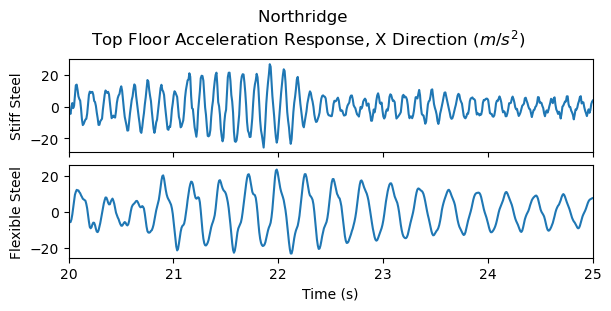

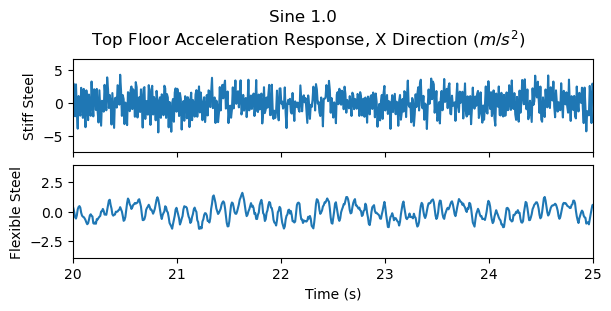

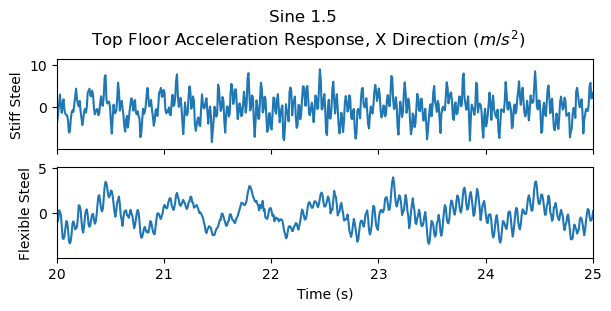

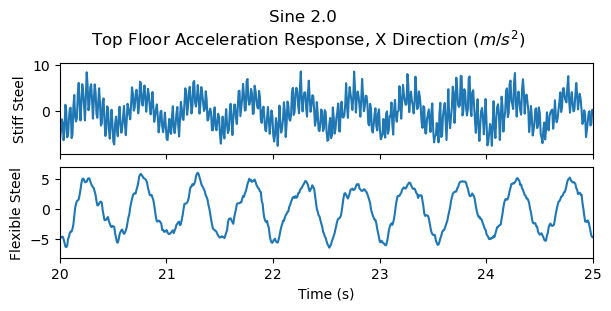

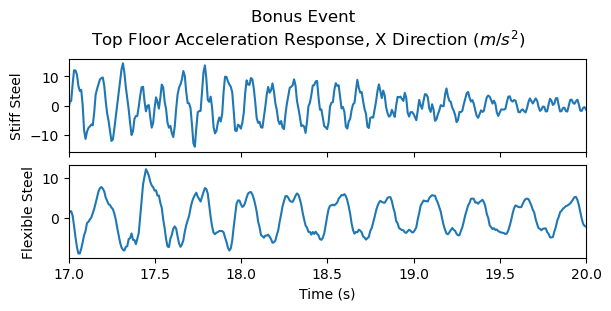

In [4]:
# Path to a directory where we'll save figures
OUT_DIR = Path("out/")
if not OUT_DIR.exists():
    OUT_DIR.mkdir()

event_names = ["Northridge", "Sine 1.0", "Sine 1.5", "Sine 2.0", "Bonus Event"]

# Loop through all events
for event_name in event_names:
    # Plot the records!
    # Only plot the top floor response.
    # Plot stiff 3 story and flexible 3 story steel side-by-side.
    outputs_stiff = data[f'Stiff 3 story 3rd Floor (Top floor) - ({event_name})']
    outputs_flex = data[f'Flexible 3 story 3rd Floor (Top floor) - ({event_name})']
    # Make the records the same length.
    npts = min(outputs_stiff.shape[0], outputs_flex.shape[0])
    outputs_stiff = outputs_stiff[:npts]
    outputs_flex = outputs_flex[:npts]
    # Construct the time array
    time = time_array(TIME_STEP, npts)
    # Create a figure with two subplots stacked vertically (2 rows, 1 column of subplots)
    fig,ax = plt.subplots(2, 1, figsize=(6,3), sharex=True, constrained_layout=True)
    # Plot the X direction, which is the first column of record
    ax[0].plot(time, outputs_stiff[:,0])
    ax[1].plot(time, outputs_flex[:,0])
    # Labels, limits and title
    ax[0].set_ylabel('Stiff Steel')
    ax[1].set_ylabel('Flexible Steel')
    ax[1].set_xlabel('Time (s)')
    ax[1].set_xlim((20,25))
    if "Bonus" in event_name:
        ax[1].set_xlim((17,20))
    fig.suptitle(f"{event_name} \n Top Floor Acceleration Response, X Direction ($m/s^2$)")
    # Save the figure
    fig.savefig(OUT_DIR/f"{event_name}.png")

### Plot the stiff one story model.

Just plot a preview of the Sine Wave record.

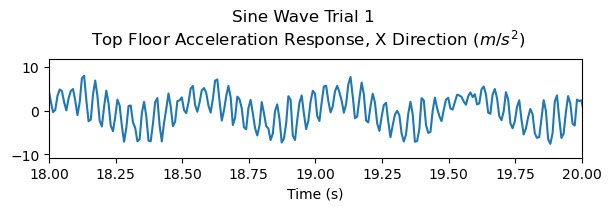

In [5]:
event_names = [
    # "El Centro Trial 1", "El Centro Trial 2", "Northridge Trial 1", "Northridge Trial 2",
    "Sine Wave Trial 1",
    # "Sine Wave Trial 2",
               ]

# Loop through all events
for event_name in event_names:
    # Plot the records!
    # Only plot the top floor response.
    outputs = data[f'Stiff 1 story Top Floor - ({event_name})']
    # Construct the time array
    npts = outputs.shape[0]
    time = time_array(TIME_STEP, npts)
    # Create a figure
    fig,ax = plt.subplots(figsize=(6,2), sharex=True, constrained_layout=True)
    # Plot the X direction, which is the first column of record
    ax.plot(time, outputs[:,0])
    # Labels, limits and title
    ax.set_xlabel('Time (s)')
    if "Sine" in event_name:
        ax.set_xlim((18,20))
    elif "El Centro" in event_name:
        ax.set_xlim((8,15))
    else:
        ax.set_xlim((5,12))
    fig.suptitle(f"{event_name} \n Top Floor Acceleration Response, X Direction ($m/s^2$)")
    # Save the figure
    fig.savefig(OUT_DIR/f"{event_name}.png")

# (3) Discussion: what can we say about how ***frequency of oscillation*** varies with ***stiffness*** of the steel walls?

How does this make sense with the relation, $\omega_{n} = \sqrt{\frac{k}{m}}$ ?

Write your observations below.

- Frequency of oscillation increases as stiffness of the steel increases.

- $k$ in the equation is stiffness. For stiffer steel, $k$ is higher.

- $m$ in the equation is mass. mass is constant.

- $\omega_{n}$ in the equation is natural frequency.

- Therefore, as stiffness increases in the equation, natural frequency increases by a square root relationship with the stiffness.

# (4) Obtain natural frequencies with system identification

## Unknown system with one input and one output

Let's treat these building models as single-degree-of-freedom oscillators with concentrated mass at the top, like the "lollipop" shown below.

This is a very common idealization for structural systems.

There are two parameters that define how this system moves: natural frequency and damping ratio.

parameter | value
----------|-------
$\omega_n$  | natural frequency
$\zeta$  | damping ratio

These two parameters can be determined experimentally by system identification of the structure's vibrations.

![sdof2](../../figures/sdof2.png)

## 3 Story Stiff Steel

In [6]:
event_names = ["Northridge", "Sine 1.0", "Sine 1.5", "Sine 2.0", "Bonus Event"]

# Loop through all events
for event_name in event_names:
    # Load the X component of the bottom sensor as input
    inputs = data[f'Stiff 3 story Ground Floor - ({event_name})'][:,0]
    # Don't use the entire time series. Start halfway through the record and end at 5/6 through.
    sixth_points = int(inputs.shape[0]/6)
    inputs = inputs[3*sixth_points:5*sixth_points]
    # Load the top sensor as output
    outputs = data[f'Stiff 3 story 3rd Floor (Top floor) - ({event_name})'][:,0][3*sixth_points:5*sixth_points]
    # Construct the time array
    time = time_array(TIME_STEP, len(inputs))
    # Use the mdof package to perform system identification and determine the natural periods
    P, Phi = mdof.modes(inputs, outputs, dt=TIME_STEP)
    # The fundamental natural period is the longest period.
    print(f"Event: {event_name} - Fundamental Period: {max(P):.3f} seconds")

Event: Northridge - Fundamental Period: 0.134 seconds
Event: Sine 1.0 - Fundamental Period: 0.125 seconds
Event: Sine 1.5 - Fundamental Period: 0.125 seconds
Event: Sine 2.0 - Fundamental Period: 0.125 seconds
Event: Bonus Event - Fundamental Period: 0.128 seconds


## 3 Story Flexible Steel

In [7]:
event_names = ["Northridge", "Sine 1.0", "Sine 1.5", "Sine 2.0", "Bonus Event"]

# Loop through all events
for event_name in event_names:
    # Load the X component of the bottom sensor as input
    inputs = data[f'Flexible 3 story Ground Floor - ({event_name})'][:,0]
    # Don't use the entire time series. Start halfway through the record and end at 5/6 through.
    sixth_points = int(inputs.shape[0]/6)
    inputs = inputs[3*sixth_points:5*sixth_points]
    # Load the top sensor as output
    outputs = data[f'Flexible 3 story 3rd Floor (Top floor) - ({event_name})'][:,0][3*sixth_points:5*sixth_points]
    # Construct the time array
    time = time_array(TIME_STEP, len(inputs))
    # Use the mdof package to perform system identification and determine the natural periods
    P, Phi = mdof.modes(inputs, outputs, dt=TIME_STEP)
    # The fundamental natural period is the longest period.
    realization = mdof.sysid(inputs, outputs)
    print(f"Event: {event_name} - Fundamental Period: {max(P):.3f} seconds")

Event: Northridge - Fundamental Period: 0.273 seconds
Event: Sine 1.0 - Fundamental Period: 4.781 seconds
Event: Sine 1.5 - Fundamental Period: 0.288 seconds
Event: Sine 2.0 - Fundamental Period: 0.267 seconds
Event: Bonus Event - Fundamental Period: 0.270 seconds


## 1 Story Stiff Steel

In [8]:
event_names = ["El Centro Trial 1", "El Centro Trial 2", "Northridge Trial 1", "Northridge Trial 2", "Sine Wave Trial 1",  "Sine Wave Trial 2"]

# Loop through all events
for event_name in event_names:
    # Load the X component of the bottom sensor as input
    inputs = data[f'Stiff 1 story Ground Floor - ({event_name})'][:,0]
    # Don't use the entire time series. Start halfway through the record and end at 5/6 through.
    sixth_points = int(inputs.shape[0]/6)
    inputs = inputs[3*sixth_points:5*sixth_points]
    # Load the top sensor as output
    outputs = data[f'Stiff 1 story Top Floor - ({event_name})'][:,0][3*sixth_points:5*sixth_points]
    # Construct the time array
    time = time_array(TIME_STEP, len(inputs))
    # Use the mdof package to perform system identification and determine the natural periods
    P, Phi = mdof.modes(inputs, outputs, dt=TIME_STEP)
    # The fundamental natural period is the longest period.
    realization = mdof.sysid(inputs, outputs)
    print(f"Event: {event_name} - Fundamental Period: {max(P):.3f} seconds")

Event: El Centro Trial 1 - Fundamental Period: 0.050 seconds
Event: El Centro Trial 2 - Fundamental Period: 0.049 seconds
Event: Northridge Trial 1 - Fundamental Period: 0.049 seconds
Event: Northridge Trial 2 - Fundamental Period: 0.049 seconds
Event: Sine Wave Trial 1 - Fundamental Period: 0.054 seconds
Event: Sine Wave Trial 2 - Fundamental Period: 0.050 seconds


# (5) Fundamental periods of the two steel models

What is your estimate of the fundamental period, in seconds, of the 3 story stiff steel model? of the 3 story flexible steel model? of the 1 story stiff steel model?

Save these values as `period_stiff3`, `period_flex3`, and `period_flex1`.

In [9]:
period_stiff3 = 0.125 # fundamental period of 3 story stiff steel model, in seconds
period_flex3 = 0.27 # fundamental period of 3 story flexible steel model, in seconds
period_stiff1 = 0.05 # fundamental period of one story stiff steel model, in seconds

# (6) Stiffness of each type of steel

Remember the relation, $\omega_{n} = \sqrt{\frac{k}{m}}$.

1. Derive this relation from the governing differential equation of motion for a single degree of freedom (undamped) harmonic oscillator in free vibration, $m\ddot{u} + ku = 0$.

2. Use the relation, along with the mass of the polycarbonate blocks to determine the stiffness of each type of steel. Assume the mass is "lumped" at the top floor, and equal to the mass of one polycarbonate block with sensor attached plus a half story of steel wall. Note: the units of stiffness should be a unit of force per unit displacement, such as kg/cm.

<p align="center">
<img src="../../figures/model_lumped_mass.png" alt="model_lumped_mass" width="400"/>
</p>

Write your answers below, or in a separate document.

1. If $m\ddot{u} + ku = 0$, then $u(t) = c_{1}\cos{\omega_{n} t} +  c_{2}\sin{\omega_{n} t}$.

How do we solve for $\omega_{n}$ in terms of the values of $m$ and $k$?


...

...

...



2. Start by calculating the "lumped mass."

$m$ = (mass of 1 polycarb block with sensor attached) + 0.5(mass of 6 inches (1 floor) of 2 steel walls).

Then compute $k$ from the relation $\omega_{n} = \sqrt{\frac{k}{m}}$.


...

...

...




#